# Уменьшение количества цветов изображения

In [ ]:
import pandas
import numpy
from sklearn.cluster import KMeans
import skimage
import skimage.io
import pylab
from typing import Tuple

### 1) Загрузка изображение и его кодирование в виде массива numpy

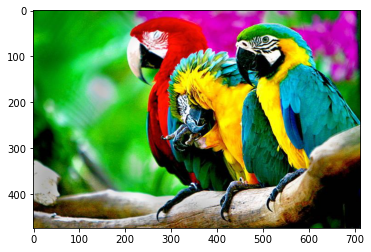

In [3]:
image = skimage.io.imread('C:/Data_P/Week_6/parrots.jpg')
pylab.imshow(image) # Открываем изображение для проверки

In [4]:
# Преобразование исходного изображения, переведя все значения в интервал [0;1]:
image_new = skimage.img_as_float(image)

### 2) Создание матрицы объекты-признаки (объект - пиксель, который характеризуется тремя координатами).

In [6]:
x1, x2, x3 = image_new.shape
matrix = pandas.DataFrame(numpy.reshape(image_new, (x1*x2, x3)), columns=["R", "G", "B"]) # Преобразовали исходный массив через reshap.

### 3) Создание функций. Выполнение алгоритма K-Means с параметрами из условия поставленной задачи.

In [7]:
# Кластеризация
def cluster_pixels(pixels: pandas.DataFrame, n_clusters: int=8) -> pandas.DataFrame:
    pixels = pixels.copy() # Создали копию
    model = KMeans(n_clusters=n_clusters, init="k-means++", random_state=241)
    pixels["cluster"] = model.fit_predict(pixels)
    return pixels

In [9]:
# Заполнение цветом
def mean_median_image(pixels: pandas.DataFrame) -> Tuple[numpy.array, numpy.array]:
    # Заполнение средним цветом по кластеру
    means = pixels.groupby("cluster").mean().values # Вычисляет среднее по классам по каждой из колонок.
    mean_pixels = numpy.array([means[c] for c in pixels["cluster"]]) # Создает array из значений means, при этом расставляем значения в соответствии с кластерами.
    mean_image = numpy.reshape(mean_pixels, (x1, x2, x3))
    # Заполнение медианным цветом по кластеру
    medians = pixels.groupby("cluster").median().values
    median_pixels = numpy.array([medians[c] for c in pixels["cluster"]])
    median_image = numpy.reshape(median_pixels, (x1, x2, x3))
    
    return mean_image, median_image

In [13]:
# Кластеризация
image_class = cluster_pixels(matrix)

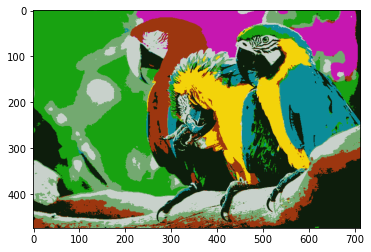

In [11]:
# Обновленная таблица, описывающая изображение (с помощью среднего цвета)
image_mean = mean_median_image(image_class)[0]
pylab.imshow(image_mean)

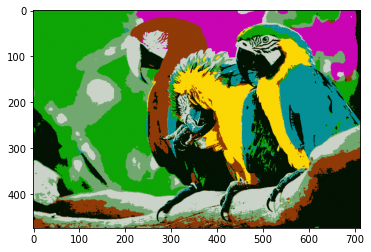

In [12]:
# Обновленная таблица, описывающая изображение (с помощью медианного цвета)
image_med = mean_median_image(image_class)[1] 
pylab.imshow(image_med)

### 4) Измерение качества с помощью метрики PSNR

In [15]:
# Реализация метрики PSNR 
def PSNR (image_1: numpy.array, image_2: numpy.array):
    MSE = numpy.mean((image_1 - image_2)**2)
    return 10 * numpy.log10(1.0/MSE) # 1.0 - ибо максимальное значение, принимаемое пикселем изображения (ранее производили нормировку так, чтобы все значения от 0 до 1 лежали).

In [16]:
# PSNR в случае заполняемости средним цветом
PSNR(image_new, image_mean)

18.436728778310275

In [17]:
# PSNR в случае заполняемости медианным цветом
PSNR(image_new, image_med)

18.146655471791103

### 5) Минимальное количество кластеров, при котором PSNR > 20

In [18]:
def PSNR_min20 (image_1, iteration: int=20):
    PSNR_data = pandas.DataFrame(columns=['clusters', 'PSNR_mean', 'PSNR_med'])
    image_mean, image_med = None, None

    image_1_norm = skimage.img_as_float(image_1) # [0:1] отнормировали.
    x1, x2, x3 = image_1_norm.shape # Размеры матрицы
    matrix = pandas.DataFrame(numpy.reshape(image_1_norm, (x1 * x2, x3)), columns=["R", "G", "B"]) # Участвует в кластеризации.
    for i in range(1, iteration):
        pixels = cluster_pixels(matrix, i)
        image_mean = mean_median_image(pixels)[0]
        image_med = mean_median_image(pixels)[1]
        PSNR(image_1_norm, image_mean)
        PSNR_data.loc[i] = [i, PSNR(image_1_norm, image_mean), PSNR(image_1_norm, image_med)]
    return PSNR_data

In [19]:
result = PSNR_min20(image, iteration = 21)

In [20]:
result
# Из таблицы видно, что при 11 кластерах значение PSNR в случае заполняемости средним цветом становится >20.

,clusters,PSNR_mean,PSNR_med
1,1.0,9.818836,9.427840
2,2.0,12.080111,11.650216
3,3.0,13.153493,12.788197
4,4.0,14.367784,14.005761
5,5.0,15.527006,15.179273
6,6.0,16.543948,16.053912
7,7.0,17.640931,17.341044
8,8.0,18.436729,18.146655
9,9.0,19.112486,18.816040
10,10.0,19.639502,19.412342


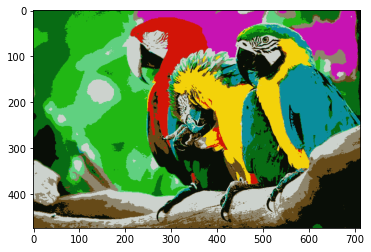

In [21]:
# Кластеризация (при делении на 11 кластеров) и заполняемость средним цветом.
image_class = cluster_pixels(matrix,  n_clusters = 11)
image_mean = mean_median_image(image_class)[0]
pylab.imshow(image_mean)